## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. An MNIST Classifier With Over 97% Accuracy

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}]
#param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [4]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  26.7s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  26.9s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  25.8s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  24.5s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  27.6s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  25.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  29.0s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  23.7s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  28.6s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  25.6s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  29.3s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [7]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [8]:
grid_search.best_score_

0.9716166666666666

In [9]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Data Augmentation

In [10]:
from scipy.ndimage.interpolation import shift

In [11]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

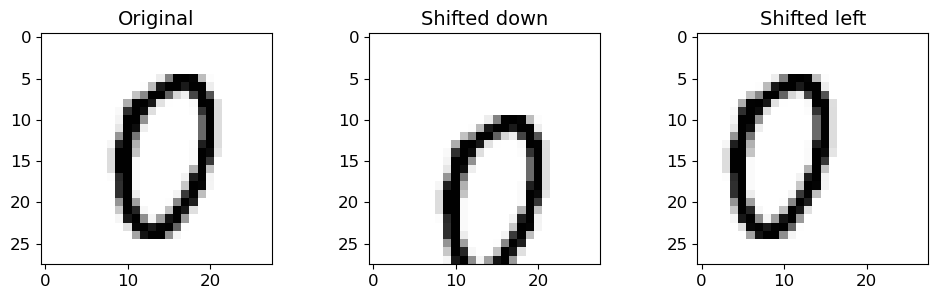

In [12]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [13]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [14]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [15]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [16]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [17]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

## 3. Tackle the Titanic dataset

### EDA

In [18]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ('train.csv', 'test.csv'):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print('Downloading', filename)
            urllib.request.urlretrieve(url+filename, filepath)
            
fetch_titanic_data()

In [19]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [20]:
train_data = load_titanic_data('train.csv')
test_data = load_titanic_data('test.csv')

In [21]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')

In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [24]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [25]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [26]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [27]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [28]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Preprocessing pipelines

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [30]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [31]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

In [32]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs]
)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [33]:
y_train = train_data['Survived']
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

### Model selection

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [36]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

In [37]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

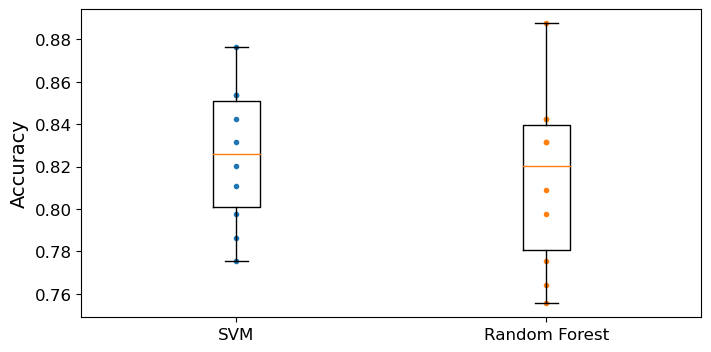

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

### Feature Engineering

In [58]:
import numpy as np
import pandas as pd

pd.cut(train_data['Age'],bins=[0., 15.0, 30.0, 45.0, 50.0, 75.0, np.inf],labels=[1, 2, 3, 4, 5, 6]).head(10)


PassengerId
1       2
2       3
3       2
4       3
5       3
6     NaN
7       5
8       1
9       2
10      1
Name: Age, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [60]:

from sklearn.preprocessing import KBinsDiscretizer

num2cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=6, encode='onehot', strategy='uniform'))
])

In [61]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [62]:
from sklearn.compose import ColumnTransformer

num_attribs = ['SibSp', 'Parch', 'Fare']
num2cat_attribs = ['Age']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('num2cat', num2cat_pipeline, num2cat_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

In [63]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + num2cat_attribs + cat_attribs]
)
X_train

array([[ 0.43279337, -0.47367361, -0.50244517, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.43279337, -0.47367361,  0.78684529, ...,  1.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361, -0.48885426, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.43279337,  2.00893337, -0.17626324, ...,  0.        ,
         0.        ,  1.        ],
       [-0.4745452 , -0.47367361, -0.04438104, ...,  1.        ,
         0.        ,  0.        ],
       [-0.4745452 , -0.47367361, -0.49237783, ...,  0.        ,
         1.        ,  0.        ]])

In [64]:
y_train = train_data['Survived']
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

### Model selection

In [67]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [70]:

X_test = preprocess_pipeline.transform(test_data[num_attribs + num2cat_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

In [71]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8103245942571785

In [72]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8226966292134831

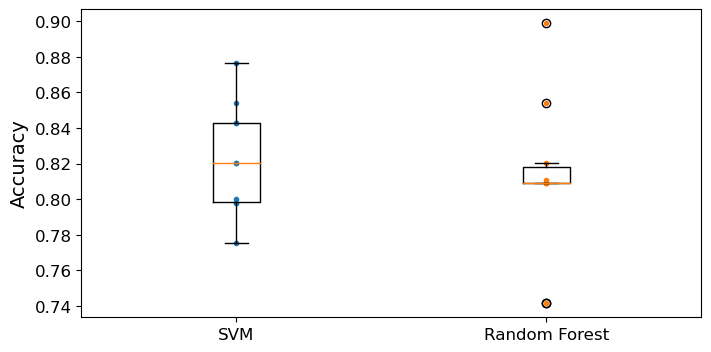

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()